In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
os.chdir("../")

In [4]:
os.chdir("../")

In [5]:
from BACKEND.INTERVIEW.HR.hr_graph import app

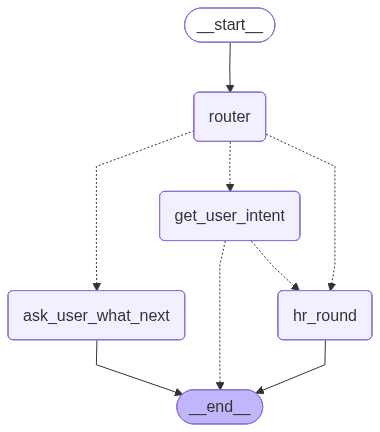

In [6]:
app

In [ ]:
# streamlit_app.py
import streamlit as st
import uuid
import requests
from typing import List, Dict

# -------------------------
# CONFIG
# -------------------------
# Default backend base URL (change to your FastAPI host/port)
BACKEND_BASE_URL = st.secrets.get("BACKEND_URL", "http://localhost:8000")

# Endpoints (adapt these to your backend)
START_ENDPOINT = BACKEND_BASE_URL + "/interview/start"          # POST -> { "user_id": "<id>", "resume": {...}, "jd": {...} }
STEP_ENDPOINT = BACKEND_BASE_URL + "/interview/step"            # POST -> { "user_id": "<id>", "user_input": "..." }
# Some backends use different shapes; adapt as necessary.

# -------------------------
# Helpers
# -------------------------
def api_start(user_id: str, resume: dict, jd: dict):
    payload = {"user_id": user_id, "resume": resume, "jd": jd}
    r = requests.post(START_ENDPOINT, json=payload, timeout=30)
    r.raise_for_status()
    return r.json()

def api_step(user_id: str, user_input: str):
    payload = {"user_id": user_id, "user_input": user_input}
    r = requests.post(STEP_ENDPOINT, json=payload, timeout=30)
    r.raise_for_status()
    return r.json()

def append_message(role: str, text: str):
    st.session_state.messages.append({"role": role, "text": text})

# -------------------------
# Session state init
# -------------------------
if "user_id" not in st.session_state:
    st.session_state.user_id = str(uuid.uuid4())
if "messages" not in st.session_state:
    st.session_state.messages: List[Dict[str, str]] = []
if "started" not in st.session_state:
    st.session_state.started = False
if "finished" not in st.session_state:
    st.session_state.finished = False
if "last_response" not in st.session_state:
    st.session_state.last_response = None

# -------------------------
# Sidebar: Upload resume & JD (or paste)
# -------------------------
st.sidebar.title("Interview Setup")
mode = st.sidebar.selectbox("Backend Mode", ["api"], index=0)
st.sidebar.write("Backend URL:", BACKEND_BASE_URL)

with st.sidebar.expander("Candidate Resume (JSON)", expanded=True):
    resume_text = st.text_area("Paste resume (JSON) or leave default", height=200)
    if not resume_text:
        # sample resume
        resume_text = """{
  "name": "John Doe",
  "skills": ["Python", "ML"],
  "experience": "2 years",
  "summary": "Data scientist with project experience in model building"
}"""
with st.sidebar.expander("Job Description (JSON)", expanded=True):
    jd_text = st.text_area("Paste JD (JSON) or leave default", height=200)
    if not jd_text:
        jd_text = """{
  "role": "Data Scientist",
  "company": "Acme Corp",
  "requirements": ["Python", "Machine Learning", "SQL"]
}"""

try:
    import json
    resume_json = json.loads(resume_text)
    jd_json = json.loads(jd_text)
except Exception as e:
    st.sidebar.error("Invalid JSON in resume/JD. Fix it before starting.")
    st.stop()

# -------------------------
# Main UI
# -------------------------
st.title("InterviewPrep — HR Agent (Mock)")
st.write("Chat-style interface for the HR agent. Press **Start Interview** to begin.")

col1, col2 = st.columns([1, 1])

with col1:
    if not st.session_state.started:
        if st.button("Start Interview"):
            try:
                resp = api_start(st.session_state.user_id, resume_json, jd_json)
            except Exception as e:
                st.error(f"Failed to call start endpoint: {e}")
            else:
                # Expect backend to return an interviewer message (response) to display
                interviewer_msg = resp.get("response") or resp.get("pending_question") or "Interviewer: Ready."
                append_message("hr", interviewer_msg)
                st.session_state.started = True
                st.session_state.last_response = interviewer_msg

with col2:
    if st.session_state.started and not st.session_state.finished:
        if st.button("End Interview (Request Report)"):
            # send a special input to trigger end/report
            try:
                r = api_step(st.session_state.user_id, "__END__")
            except Exception as e:
                st.error(f"Failed to call step endpoint: {e}")
            else:
                report = r.get("report") or r.get("response") or "Interview ended."
                append_message("hr", report)
                st.session_state.finished = True

# -------------------------
# Chat Log
# -------------------------
st.markdown("### Conversation")
for msg in st.session_state.messages:
    if msg["role"] == "hr":
        st.markdown(f"**Interviewer:** {msg['text']}")
    else:
        st.markdown(f"**Candidate:** {msg['text']}")

st.markdown("---")

# Quick reply buttons
if st.session_state.started and not st.session_state.finished:
    cols = st.columns(4)
    if cols[0].button("I'm ready"):
        user_text = "I am ready"
        append_message("user", user_text)
        try:
            resp = api_step(st.session_state.user_id, user_text)
        except Exception as e:
            st.error(f"Error: {e}")
        else:
            hr_text = resp.get("response") or resp.get("next_question") or ""
            append_message("hr", hr_text)
            if resp.get("finished") or resp.get("section_name") == "end":
                st.session_state.finished = True
    if cols[1].button("Repeat"):
        user_text = "Please repeat this section"
        append_message("user", user_text)
        try:
            resp = api_step(st.session_state.user_id, user_text)
        except Exception as e:
            st.error(f"Error: {e}")
        else:
            append_message("hr", resp.get("response") or "")
    if cols[2].button("Next"):
        user_text = "Let's move to next"
        append_message("user", user_text)
        try:
            resp = api_step(st.session_state.user_id, user_text)
        except Exception as e:
            st.error(f"Error: {e}")
        else:
            append_message("hr", resp.get("response") or "")
            if resp.get("section_name") == "end" or resp.get("finished"):
                st.session_state.finished = True
    if cols[3].button("Request Report"):
        user_text = "Please give me the report"
        append_message("user", user_text)
        try:
            resp = api_step(st.session_state.user_id, user_text)
        except Exception as e:
            st.error(f"Error: {e}")
        else:
            append_message("hr", resp.get("report") or resp.get("response") or "")

# -------------------------
# Free text input
# -------------------------
if st.session_state.started and not st.session_state.finished:
    user_input = st.text_input("Type your answer and press Enter", key="user_input_text")
    if user_input:
        append_message("user", user_input)
        try:
            resp = api_step(st.session_state.user_id, user_input)
        except Exception as e:
            st.error(f"Error communicating with backend: {e}")
        else:
            # Expect backend to return e.g. {"response": "...", "section_name": "...", "finished": bool, "report": "..."}
            hr_text = resp.get("response") or resp.get("next_question") or ""
            append_message("hr", hr_text)
            st.session_state.last_response = hr_text
            if resp.get("section_name") == "end" or resp.get("finished"):
                st.session_state.finished = True
        # clear input box
        st.experimental_rerun()

# -------------------------
# Finished state
# -------------------------
if st.session_state.finished:
    st.success("Interview finished. You can view the final report above or request a new session.")
    if st.button("Start New Interview"):
        st.session_state.messages = []
        st.session_state.started = False
        st.session_state.finished = False
        st.session_state.user_id = str(uuid.uuid4())
        st.experimental_rerun()